In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pandas as pd
from datetime import datetime
import time

# # Assuming evaluate is defined elsewhere
# # from your_module import evaluate
import torch.optim as optim

from tqdm.auto import tqdm
from collections.abc import Iterable
import perceval as pcvl
from boson_sampler import BosonSampler
import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from utils import MNIST_partial, accuracy, plot_training_metrics

# from model import MnistModel, evaluate
import torch.nn as nn
import torch.nn.functional as F

# simulator = pcvl.Simulator(pcvl.NaiveBackend())
from scipy.optimize import minimize


from torchmps import MPS

import warnings

warnings.filterwarnings("ignore")

In [2]:
# device = torch.device("cpu")
device = torch.device("cuda:0")

Boson sampler defined with number of parameters = 108, and embedding size = 126


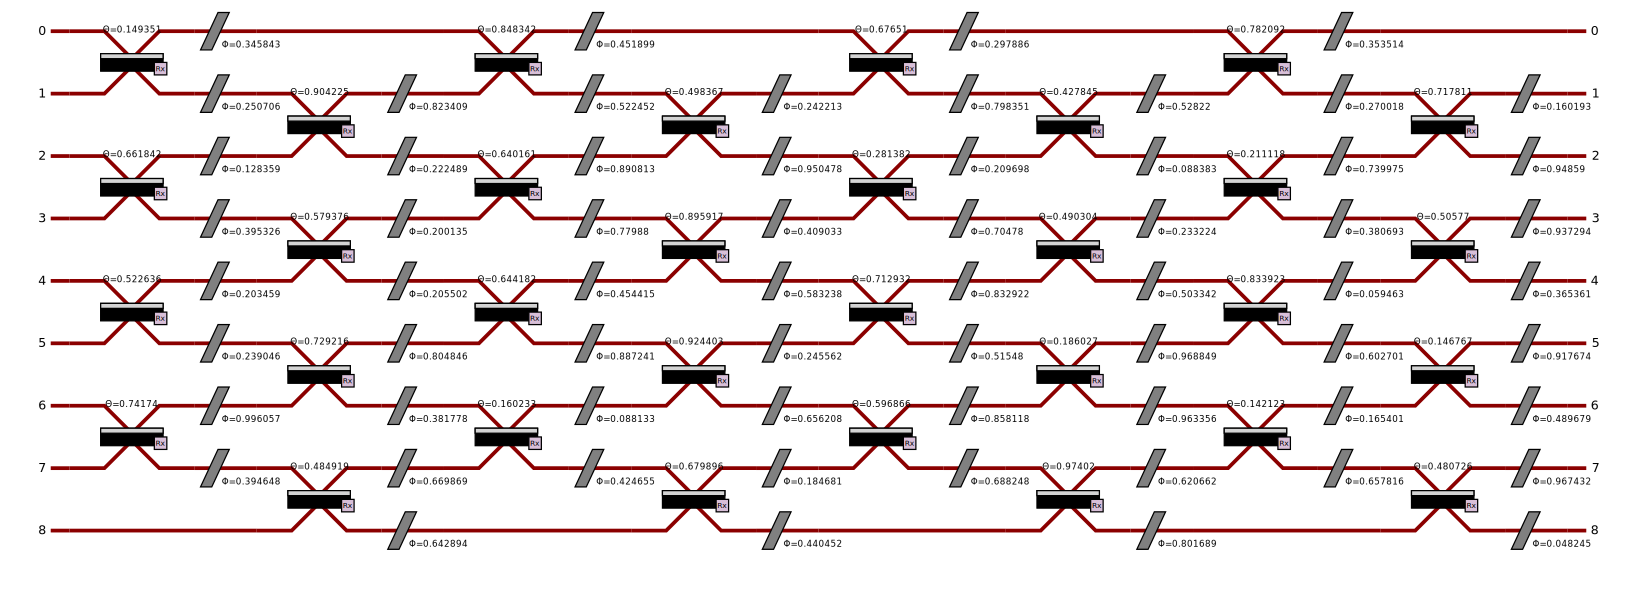

In [3]:
#### START SCALEWAY SESSION ####
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#### BOSON SAMPLER DEFINITION ####

bs_1 = BosonSampler(m=9, n=4, session=session)
print(
    f"Boson sampler defined with number of parameters = {bs_1.nb_parameters}, and embedding size = {bs_1.embedding_size}"
)
# to display it
pcvl.pdisplay(bs_1.create_circuit())

Boson sampler defined with number of parameters = 84, and embedding size = 70


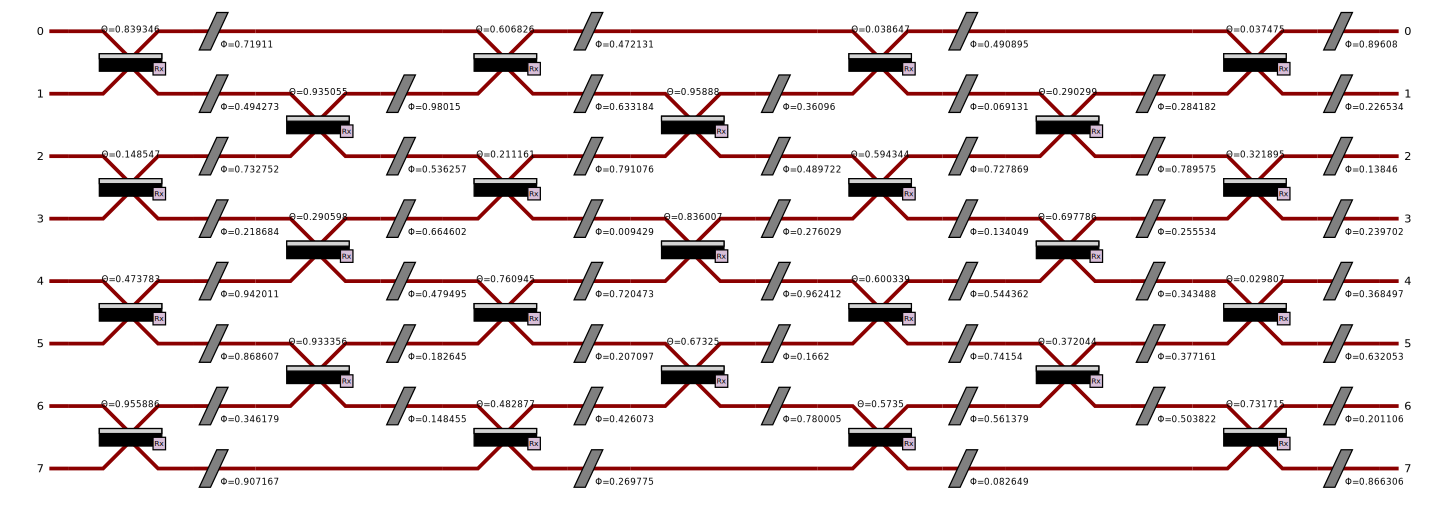

In [4]:
bs_2 = BosonSampler(m=8, n=4, session=session)
print(
    f"Boson sampler defined with number of parameters = {bs_2.nb_parameters}, and embedding size = {bs_2.embedding_size}"
)
# to display it
pcvl.pdisplay(bs_2.create_circuit())

In [ ]:
print(f"Maximun weight size to generate: {bs_1.embedding_size * bs_2.embedding_size}")

In [ ]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 12, kernel_size=5)
        self.fc1 = nn.Linear(12 * 4 * 4, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)  # [N, 32 * 8 * 8]
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split="train")
val_dataset = MNIST_partial(split="val")

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [ ]:
# learning_rate = 1e-3
# num_epochs = 1
# Instantiate the model and loss function
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = CNNModel()
num_classical_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("# of parameters in classical CNN model: ", num_classical_parameter)

In [ ]:
# # Training loop
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 100 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


In [ ]:
# # Testing loop
# model.eval()
# correct = 0
# total = 0
# loss_test_list = []
# with torch.no_grad():
#     for images, labels in val_loader:
#         outputs = model(images)
#         loss_test = criterion(outputs, labels).cpu().detach().numpy()
#         loss_test_list.append(loss_test)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")


In [ ]:
### required qubits estimation ##############
# NN weights

numpy_weights = {}
nw_list = []
nw_list_normal = []
for name, param in model.state_dict().items():
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
# print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

#############################################

In [ ]:
# len(np.zeros(126)[63:])

In [ ]:
### Some tool function definition ###########
def probs_to_weights(probs_):
    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for name, param in CNNModel().state_dict().items():
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        new_state_dict[name] = chunk
        data_iterator = data_iterator[num_elements:]

    return new_state_dict


def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    # To represent distinct basis
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states


#############################################

### Main Photonic Quantum-Train model ##


class PhotonicQuantumTrain(nn.Module):
    def __init__(self):
        """ """
        super().__init__()
        self.MappingNetwork = MPS(
            input_dim=n_qubit + 1, output_dim=1, bond_dim=bond_dim
        )

    def forward(self, x, qnn_parameters):
        """ """
        self.q_params_1 = qnn_parameters[: bs_1.nb_parameters]
        self.q_params_2 = qnn_parameters[bs_1.nb_parameters :]
        device = x.device

        res_1 = bs_1.run(parameters=self.q_params_1, samples=100000)
        trans_res_1 = bs_1.translate_results(res=res_1)
        trans_res_1 = trans_res_1 / torch.mean(trans_res_1)
        probs_1 = trans_res_1.to(device)

        res_2 = bs_2.run(parameters=self.q_params_2, samples=100000)
        trans_res_2 = bs_2.translate_results(res=res_2)
        trans_res_2 = trans_res_2 / torch.mean(trans_res_2)
        probs_2 = trans_res_2.to(device)

        probs_ = torch.ger(probs_1, probs_2).flatten().reshape(126 * 70, 1)

        probs_ = probs_[: len(nw_list_normal)]
        probs_ = probs_.reshape(len(nw_list_normal), 1)

        # Generate qubit states using PyTorch
        # This is just for basis representation, not necessary equivalent in the photonic case
        qubit_states_torch = generate_qubit_states_torch(n_qubit)[: len(nw_list_normal)]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(
            len(nw_list_normal), n_qubit + 1
        )

        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = (
            prob_val_post_processed - prob_val_post_processed.mean()
        )

        state_dict = probs_to_weights(prob_val_post_processed)

        ########

        dtype = torch.float32  # Ensure all tensors are of this type

        # Convolution layer 1 parameters
        conv1_weight = state_dict["conv1.weight"].to(device).type(dtype)
        conv1_bias = state_dict["conv1.bias"].to(device).type(dtype)

        # Convolution layer 2 parameters
        conv2_weight = state_dict["conv2.weight"].to(device).type(dtype)
        conv2_bias = state_dict["conv2.bias"].to(device).type(dtype)

        # Fully connected layer 1 parameters
        fc1_weight = state_dict["fc1.weight"].to(device).type(dtype)
        fc1_bias = state_dict["fc1.bias"].to(device).type(dtype)

        # Fully connected layer 2 parameters
        fc2_weight = state_dict["fc2.weight"].to(device).type(dtype)
        fc2_bias = state_dict["fc2.bias"].to(device).type(dtype)

        # Convolution 1
        x = F.conv2d(x, conv1_weight, conv1_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Convolution 2
        x = F.conv2d(x, conv2_weight, conv2_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected 1
        x = F.linear(x, fc1_weight, fc1_bias)

        # Fully connected 2
        x = F.linear(x, fc2_weight, fc2_bias)

        return x

In [ ]:
### Training setting ########################
num_epochs = 5  # number of training epochs per training round for TN mapping model
step = 1e-3  # Learning rate
gamma_lr_scheduler = 0.1  # Learning rate reduction applied every 10 epochs.
q_delta = (
    2 * np.pi
)  # Phases are 2 pi periodic --> we get better expressivity by multiplying the values by 2 pi
bond_dim = 1  # Bond dimension of tensor network mapping model

init_qnn_parameters = q_delta * np.random.rand(108 + 84)

qnn_parameters = init_qnn_parameters

# Instantiate the model, move it to GPU (if possible), and set up loss function and optimizer
qt_model = PhotonicQuantumTrain().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(qt_model.parameters(), lr=step)
num_trainable_params = sum(p.numel() for p in qt_model.parameters() if p.requires_grad)
print("# of trainable parameter in Mapping model: ", num_trainable_params)
print(
    "# of trainable parameter in QNN model: ", bs_1.nb_parameters + bs_2.nb_parameters
)
print(
    "# of trainable parameter in full model: ",
    num_trainable_params + bs_1.nb_parameters + bs_2.nb_parameters,
)

In [ ]:
num_training_rounds = 200
batch_size_qnn = 1000
train_loader_qnn = DataLoader(train_dataset, batch_size_qnn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

global images, labels

#############################################
### Training loop ###########################
#############################################


loss_list_epoch = []
acc_list_epoch = []
for round_ in range(num_training_rounds):
    print("-----------------------")

    acc_list = []
    acc_best = 0
    for epoch in range(num_epochs):
        qt_model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            correct = 0
            total = 0
            since_batch = time.time()

            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            # Forward pass
            outputs = qt_model(images, qnn_parameters=qnn_parameters)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Compute loss
            loss = criterion(outputs, labels)
            acc = 100 * correct / total
            acc_list.append(acc)
            train_loss += loss.cpu().detach().numpy()

            if acc > acc_best:
                acc_best = acc
            # Backward pass and optimization
            loss.backward()

            optimizer.step()
            if (i + 1) % 20 == 0:
                print(
                    f"Training round [{round_ + 1}/{num_training_rounds}], Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, accuracy:  {(acc):.2f}%"
                )

        train_loss /= len(train_loader)

    #############################################

    num_batch_qnn = 1

    for batch_ in range(num_batch_qnn):
        global qnn_train_step
        qnn_train_step = 0

        # Get a single random batch
        train_iter = iter(train_loader_qnn)  # Create an iterator
        images, labels = next(train_iter)

        def qnn_minimize_loss(qnn_parameters_=None):
            global qnn_train_step
            global images, labels

            correct = 0
            total = 0

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = qt_model(images, qnn_parameters=qnn_parameters_)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            loss = loss.cpu().detach().numpy()
            acc = 100 * correct / total

            qnn_train_step += 1
            if qnn_train_step % 100 == 0:
                print(
                    f"Training round [{round_ + 1}/{num_training_rounds}], qnn_train_step: [{qnn_train_step}/{1000}], loss: {loss}, accuracy: {acc} %"
                )

            return loss

        # Nelder-Mead
        # COBYLA
        # SLSQP

        init_param = qnn_parameters
        result = minimize(
            qnn_minimize_loss,
            init_param,
            method="COBYLA",
            options={"maxiter": 1000, "adaptive": True},
        )

        qnn_parameters = result.x

    loss_list_epoch.append(loss)
    acc_list_epoch.append(acc)

In [ ]:
plt.plot([loss_i.cpu().detach() for loss_i in loss_list_epoch])
# plt.ylim(0.5, 2.5)
plt.show()


plt.plot(acc_list_epoch)
plt.show()

In [ ]:
print([float(loss_i.cpu().detach()) for loss_i in loss_list_epoch])
print(acc_list_epoch)
# loss_list_epoch_ = [2.181758403778076, 2.0800328254699707, 1.9113519191741943, 1.7873510122299194, 2.010037899017334, 1.6513739824295044, 1.7825473546981812, 1.707285761833191, 1.6182714700698853, 1.6775875091552734, 1.7792770862579346, 1.5184249877929688, 1.613982081413269, 1.582148790359497, 1.5099925994873047, 1.5111676454544067, 1.5821151733398438, 1.3782964944839478, 1.5507811307907104, 1.4803277254104614, 1.5449422597885132, 1.3644582033157349, 1.5389660596847534, 1.388230562210083, 1.4657150506973267, 1.3372951745986938, 1.3690675497055054, 1.4174163341522217, 1.332667589187622, 1.2755534648895264, 1.4989807605743408, 1.3738235235214233, 1.3766955137252808, 1.3186330795288086, 1.2987433671951294, 1.3430877923965454, 1.1920098066329956, 1.2732549905776978, 1.313113808631897, 1.3439140319824219, 1.273341178894043, 1.2552624940872192, 1.4518897533416748, 1.2770353555679321, 1.2692269086837769, 1.32889723777771, 1.4667245149612427, 1.183014154434204, 1.2832908630371094, 1.526262640953064, 1.3969553709030151, 1.4551345109939575, 1.2529014348983765, 1.269129991531372, 1.2660857439041138, 1.3396437168121338, 1.3297064304351807, 1.3368031978607178, 1.323429822921753, 1.2604036331176758, 1.286124348640442, 1.2277231216430664, 1.3039203882217407, 1.4600270986557007, 1.2554348707199097, 1.356606364250183, 1.386740803718567, 1.1783103942871094, 1.1205838918685913, 1.3522627353668213, 1.2018154859542847, 1.1229127645492554, 1.2872291803359985, 1.1772546768188477, 1.214295744895935, 1.333033800125122, 1.3178682327270508, 1.109094262123108, 1.392215609550476, 1.418505311012268, 1.517653226852417, 1.2559953927993774, 1.3089559078216553, 1.269590139389038, 1.272265076637268, 1.188071608543396, 1.2733105421066284, 1.3886979818344116, 1.3456918001174927, 1.1471779346466064, 1.3745677471160889, 1.2683442831039429, 1.235698938369751, 1.232881784439087, 1.1579028367996216, 1.2386480569839478, 1.3132861852645874, 1.4662226438522339, 1.335034728050232, 1.1445297002792358, 1.1835731267929077, 1.1042321920394897, 1.1467297077178955, 1.318407416343689, 1.2307922840118408, 1.3246859312057495, 1.2954763174057007, 1.1391161680221558, 1.2673819065093994, 1.4617633819580078, 1.2026783227920532, 1.242130160331726, 1.0252546072006226, 1.2436681985855103, 1.3377313613891602, 1.2418862581253052, 1.1981217861175537, 1.0359219312667847, 1.4083162546157837, 1.2499717473983765, 1.4352489709854126, 1.3252525329589844, 1.2754875421524048, 1.3823469877243042, 1.4201316833496094, 1.3396159410476685, 1.0669749975204468, 1.066733479499817, 1.3329380750656128, 1.1660356521606445, 1.257463812828064, 1.3749560117721558, 1.3424235582351685, 1.2410694360733032, 1.3309400081634521, 1.3215464353561401, 1.5480822324752808, 1.164183497428894, 1.3782432079315186, 1.1613460779190063, 1.2386778593063354, 1.2876695394515991, 1.0774728059768677, 1.3293523788452148, 1.2220085859298706, 1.225321888923645, 1.207922339439392, 1.0817488431930542, 1.1480398178100586, 1.2403888702392578, 1.2670297622680664, 1.3535255193710327, 1.23381769657135, 1.1537551879882812, 1.198246955871582, 1.0624487400054932, 1.3231946229934692, 1.04517662525177, 1.2314239740371704, 1.2562955617904663, 0.9647848010063171, 1.148559331893921, 1.0539649724960327, 1.2239235639572144, 1.4946081638336182, 1.1764888763427734, 1.3440656661987305, 1.2643102407455444, 1.148903250694275, 1.0862091779708862, 1.1565221548080444, 1.2101253271102905, 1.06053626537323, 1.2440563440322876, 1.132211446762085, 1.2512319087982178, 1.2562793493270874, 1.2431327104568481, 1.2919228076934814, 1.201576590538025, 1.0369642972946167, 1.3534268140792847, 1.1693713665008545, 1.0815515518188477, 1.0685991048812866, 1.260898232460022, 1.0983182191848755, 1.013895869255066, 1.298538088798523, 1.3364924192428589, 1.1518117189407349, 1.2480412721633911, 1.0587397813796997, 1.110772967338562, 1.3706262111663818, 0.9972884058952332, 1.2655360698699951, 1.4233003854751587, 1.217613935470581, 1.3071744441986084]
# acc_list_epoch_ = [18.75, 21.428571428571427, 25.892857142857142, 32.142857142857146, 22.321428571428573, 35.714285714285715, 35.714285714285715, 31.25, 31.25, 40.17857142857143, 33.92857142857143, 47.32142857142857, 41.07142857142857, 42.857142857142854, 34.82142857142857, 41.07142857142857, 47.32142857142857, 49.107142857142854, 45.535714285714285, 43.75, 43.75, 47.32142857142857, 37.5, 41.07142857142857, 40.17857142857143, 54.464285714285715, 50.892857142857146, 43.75, 50.0, 56.25, 37.5, 49.107142857142854, 53.57142857142857, 56.25, 59.82142857142857, 50.0, 55.357142857142854, 57.142857142857146, 52.67857142857143, 52.67857142857143, 56.25, 44.642857142857146, 39.285714285714285, 58.92857142857143, 52.67857142857143, 51.785714285714285, 53.57142857142857, 62.5, 48.214285714285715, 50.0, 55.357142857142854, 37.5, 52.67857142857143, 57.142857142857146, 52.67857142857143, 54.464285714285715, 51.785714285714285, 49.107142857142854, 54.464285714285715, 57.142857142857146, 50.892857142857146, 57.142857142857146, 56.25, 48.214285714285715, 53.57142857142857, 52.67857142857143, 50.0, 58.035714285714285, 60.714285714285715, 56.25, 55.357142857142854, 66.07142857142857, 48.214285714285715, 61.607142857142854, 55.357142857142854, 52.67857142857143, 58.92857142857143, 61.607142857142854, 52.67857142857143, 46.42857142857143, 54.464285714285715, 50.892857142857146, 50.0, 54.464285714285715, 53.57142857142857, 60.714285714285715, 49.107142857142854, 49.107142857142854, 60.714285714285715, 58.035714285714285, 57.142857142857146, 54.464285714285715, 55.357142857142854, 59.82142857142857, 58.035714285714285, 48.214285714285715, 55.357142857142854, 55.357142857142854, 54.464285714285715, 58.92857142857143, 59.82142857142857, 58.035714285714285, 64.28571428571429, 54.464285714285715, 59.82142857142857, 49.107142857142854, 54.464285714285715, 60.714285714285715, 55.357142857142854, 58.035714285714285, 52.67857142857143, 61.607142857142854, 66.07142857142857, 57.142857142857146, 54.464285714285715, 58.92857142857143, 57.142857142857146, 66.07142857142857, 51.785714285714285, 51.785714285714285, 50.0, 57.142857142857146, 55.357142857142854, 51.785714285714285, 55.357142857142854, 50.892857142857146, 59.82142857142857, 63.392857142857146, 50.0, 64.28571428571429, 53.57142857142857, 54.464285714285715, 56.25, 58.92857142857143, 49.107142857142854, 50.892857142857146, 45.535714285714285, 59.82142857142857, 46.42857142857143, 54.464285714285715, 62.5, 57.142857142857146, 61.607142857142854, 45.535714285714285, 50.892857142857146, 51.785714285714285, 52.67857142857143, 62.5, 57.142857142857146, 60.714285714285715, 58.92857142857143, 55.357142857142854, 50.0, 55.357142857142854, 60.714285714285715, 56.25, 55.357142857142854, 66.07142857142857, 58.92857142857143, 55.357142857142854, 64.28571428571429, 58.035714285714285, 62.5, 60.714285714285715, 50.0, 53.57142857142857, 50.892857142857146, 51.785714285714285, 55.357142857142854, 58.92857142857143, 55.357142857142854, 54.464285714285715, 60.714285714285715, 57.142857142857146, 61.607142857142854, 56.25, 56.25, 57.142857142857146, 59.82142857142857, 56.25, 65.17857142857143, 56.25, 61.607142857142854, 66.07142857142857, 58.035714285714285, 53.57142857142857, 57.142857142857146, 66.07142857142857, 51.785714285714285, 47.32142857142857, 54.464285714285715, 58.92857142857143, 53.57142857142857, 60.714285714285715, 60.714285714285715, 61.607142857142854, 56.25, 44.642857142857146, 53.57142857142857, 53.57142857142857]

In [ ]:
# Testing train loop
qt_model.eval()
correct = 0
total = 0
loss_train_list = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = qt_model(images, qnn_parameters)
        loss_train = criterion(outputs, labels).cpu().detach().numpy()
        loss_train_list.append(loss_train)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")

# Testing loop
qt_model.eval()
correct = 0
total = 0
loss_test_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = qt_model(images, qnn_parameters)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))